In [1]:
import argparse
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import torch
import uuid


from botorch.models import SingleTaskGP, ModelListGP
from botorch import fit_gpytorch_model
from botorch.optim.fit import fit_gpytorch_torch
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import PosteriorMean
from botorch.optim import optimize_acqf
from common import seed_generator, configs
from common.utils import get_int, get_qe
from common import utils
from fireworks import LaunchPad
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints.constraints import GreaterThan
from jobflow import JobStore
from jobflow.managers.fireworks import flow_to_workflow
from maggma.stores.mongolike import MongoStore
from NanoParticleTools.flows.flows import get_npmc_flow
from NanoParticleTools.inputs.nanoparticle import SphericalConstraint
from random import randrange


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


ModuleNotFoundError: No module named 'common'

In [2]:
def get_data_botorch(data_file, from_cloud = True):
    if from_cloud:
        df = gcloud_utils.get_df_gspread(GSPREAD_CRED, GSPREAD_NAME)
        #df = df.drop(labels=range(1, 600), axis=0)
        my_data = df.to_numpy()
        print(f"reading data log from google sheet: {GSPREAD_NAME}!")
    else:
        my_data = np.loadtxt(data_file, delimiter=',', skiprows=1)
        print(f"reading data log from local: {data_file}!")

    # features
    train_x = torch.from_numpy(my_data[:, :5])
    # labels
    train_y = torch.from_numpy(my_data[:, 5]).unsqueeze(-1)
    # best observation
    best_y = train_y.max().item()
    
    return train_x, train_y, best_y


def encode_inputs(x_arr, x_max = 34):
    '''encode simulation input to botorch'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0] = arr[0] + arr[1]
        if arr[0] + arr[1] == 0:
            x_arr[i, 1] = 0.5
        else:
            x_arr[i, 1] = arr[0] / (arr[0] + arr[1])
        x_arr[i, 2] = arr[2] + arr[3]
        if arr[2] + arr[3] == 0:
            x_arr[i, 3] = 0.5
        else:
            x_arr[i, 3] = arr[2] / (arr[2] + arr[3])
        x_arr[i, 4] = arr[4] / x_max


def decode_candidates(x_arr, x_max = 34):
    '''decode botorch recommendation candidates for simulation'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0], x_arr[i, 1] = arr[0] * arr[1], arr[0] * (1 - arr[1])
        x_arr[i, 2], x_arr[i, 3] = arr[2] * arr[3], arr[2] * (1 - arr[3])
        x_arr[i, 4] = arr[4] * x_max

def recommend(train_x, train_y, best_y, bounds, n_trails = 5):
    if isinstance(bounds, list):
        bounds = torch.tensor(bounds)
    elif torch.is_tensor(bounds):
        pass
    else:
        raise TypeError(f"expect bounds in a list or tensor. was given {type(bounds)}")
    
    single_model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    
    # Expected Improvement acquisition function
    EI = qExpectedImprovement(model = single_model, best_f = best_y)
    # Upper Confidence Bound acquisition function
    UCB = UpperConfidenceBound(single_model, beta=100)
    
    # hyperparameters are super sensitive here
    candidates, _ = optimize_acqf(acq_function = UCB,
                                 bounds = bounds, 
                                 q = n_trails, 
                                 num_restarts = 20, 
                                 raw_samples = 512, 
                                # options = {'batch_limit': 5, "maxiter": 200}
                                 )
    
    return candidates
# New functions for pool-based AL. Different from real-test AL.

# recommend the next NP from the pool
def recommend_next(train_X,train_Y,test_X, beta):
    single_model = SingleTaskGP(train_X,train_Y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    UCB = UpperConfidenceBound(single_model, beta)

    ucb = UCB(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ucb.detach().numpy())
    max_ucb = max(ucb.detach().numpy())
    if max_ucb != ucb.detach().numpy()[max_idx]:
        print('wrong index')
    return max_idx, test_X[max_idx], test_y[max_idx]

# recommend the next NP from the pool
def recommend_next_logEmission(train_X,train_Y,test_X, beta):
    single_model = SingleTaskGP(train_X,np.log(train_Y+1))
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    UCB = UpperConfidenceBound(single_model, beta)

    ucb = UCB(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ucb.detach().numpy())
    max_ucb = max(ucb.detach().numpy())
    if max_ucb != ucb.detach().numpy()[max_idx]:
        print('wrong index')
    return max_idx, test_X[max_idx], test_y[max_idx]

# recommend the next NP from the pool
def recommend_next_customKernel_noise_proior(train_X,train_Y,test_X, beta):
    noise_prior = GammaPrior(1.1, 0.05)
    noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
    MIN_INFERRED_NOISE_LEVEL = 1e-5
    likelihood = GaussianLikelihood(
        noise_prior=noise_prior,
        noise_constraint=GreaterThan(
            MIN_INFERRED_NOISE_LEVEL,
            transform=None,
            initial_value=noise_prior_mode,
        ),
    )
    single_model = SimpleCustomGP(train_X=train_X, train_Y=train_Y, likelihood=likelihood)

    #single_model = SimpleCustomGP(train_X,train_Y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
#     fit_gpytorch_model(mll, optimizer=fit_gpytorch_torch)
    UCB = UpperConfidenceBound(single_model, beta)

    ucb = UCB(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ucb.detach().numpy())
    max_ucb = max(ucb.detach().numpy())
    if max_ucb != ucb.detach().numpy()[max_idx]:
        print('wrong index')
    return max_idx, test_X[max_idx], test_y[max_idx]
def recommend_next_customKernel_test(train_X,train_Y,test_X, beta):
    single_model = SimpleCustomGP(train_X,train_Y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
#     fit_gpytorch_model(mll, optimizer=fit_gpytorch_torch)
    UCB = UpperConfidenceBound(single_model, beta)

    ucb = UCB(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ucb.detach().numpy())
    max_ucb = max(ucb.detach().numpy())
    if max_ucb != ucb.detach().numpy()[max_idx]:
        print('wrong index')
    return max_idx, test_X[max_idx], test_y[max_idx]

def recommend_next_customKernel_log(train_X,train_Y,test_X, beta):
    single_model = SimpleCustomGP(train_X,np.log(train_Y+1))
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    UCB = UpperConfidenceBound(single_model, beta)

    ucb = UCB(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ucb.detach().numpy())
    max_ucb = max(ucb.detach().numpy())
    if max_ucb != ucb.detach().numpy()[max_idx]:
        print('wrong index')
    return max_idx, test_X[max_idx], test_y[max_idx]

def recommend_next_PI_log(train_X,train_Y,test_X):
    single_model = SingleTaskGP(train_X,np.log(train_Y+1))
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    best_Y = max(np.log(train_Y+1))
    print(best_Y)
    
    PI = ProbabilityOfImprovement(model = single_model, best_f = best_Y)
    pi = PI(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(pi.detach().numpy())
    max_pi = max(pi.detach().numpy())
    if max_pi != pi.detach().numpy()[max_idx]:
        print('wrong index')
        print(f'max_pi ({max_pi}) != pi[max_idx]({pi.detach().numpy()[max_idx]})')
    return max_idx, test_X[max_idx], test_y[max_idx]

def recommend_next_PI(train_X,train_Y,test_X):
    best_Y = max(train_Y)
    print(best_Y)
    single_model = SingleTaskGP(train_X,train_Y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    PI = ProbabilityOfImprovement(model = single_model, best_f = best_Y)
    pi = PI(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(pi.detach().numpy())
    max_pi = max(pi.detach().numpy())
    if max_pi != pi.detach().numpy()[max_idx]:
        print('wrong index')
        print(f'max_pi ({max_pi}) != pi[max_idx]({pi.detach().numpy()[max_idx]})')
    return max_idx, test_X[max_idx], test_y[max_idx]

def recommend_next_EI_log(train_X,train_Y,test_X):
    single_model = SingleTaskGP(train_X,np.log(train_Y+1))
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    best_Y = max(np.log(train_Y+1))
    print(best_Y)
    #qEI
    EI = qExpectedImprovement(model = single_model, best_f = best_Y)
    #PI
    #EI = ProbabilityOfImprovement(model = single_model, best_f = best_Y)
    ei = EI(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ei.detach().numpy())
    max_ei = max(ei.detach().numpy())
    if max_ei != ei.detach().numpy()[max_idx]:
        print('wrong index')
        print(f'max_ei ({max_ei}) != ei[max_idx]({ei.detach().numpy()[max_idx]})')
    return max_idx, test_X[max_idx], test_y[max_idx]

def recommend_next_EI(train_X,train_Y,test_X):
    best_Y = max(train_Y)
    print(best_Y)
    single_model = SingleTaskGP(train_X,train_Y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    #qEI
    EI = qExpectedImprovement(model = single_model, best_f = best_Y)
    #PI
    #EI = ProbabilityOfImprovement(model = single_model, best_f = best_Y)
    ei = EI(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ei.detach().numpy())
    max_ei = max(ei.detach().numpy())
    if max_ei != ei.detach().numpy()[max_idx]:
        print('wrong index')
        print(f'max_ei ({max_ei}) != ei[max_idx]({ei.detach().numpy()[max_idx]})')
    return max_idx, test_X[max_idx], test_y[max_idx]

def recommend_next_RS(train_X,train_Y,test_X):
    max_idx = randrange(len(test_X))
    return max_idx, test_X[max_idx], test_y[max_idx]
    
# log results to csv
def log_result(test_X,test_Y,max_idx,data_dest):
    decode_candidates(test_X)
    features = test_X[max_idx].numpy()
    obs = test_Y[max_idx].numpy()
    df_features = pd.DataFrame(features.reshape(-1, len(features)))
    df_obs = pd.DataFrame(obs)
    df_log = pd.concat([df_features,df_obs],axis=1)
    df_log.columns =['yb_1', 'er_1', 'yb_2', 'er_2','radius','UV']
    log = pd.read_csv(data_dest)
    log = log.append(df_log, ignore_index=True)
    log.to_csv(data_dest, index=False)

# append results to a list
# test_X: features of a sample
# test_Y: obs of a sample
# max_idx: the index of the just evaluated sample in the pool
# log: the list to append results (test_X, test_Y, max_idx)
def append_result(test_X,test_Y,max_idx,log):
    decode_candidates(test_X)
    features = test_X[max_idx].numpy()
    obs = test_Y[max_idx].numpy()
    result = np.concatenate((features, obs), axis=None)
    log.append(result)
    
# update pool: removing the new recommended NP from the pool
def update_pool(train_X,train_Y,test_X,test_Y,pool_X, pool_Y, max_idx):
    train_X, train_Y = torch.cat([train_X,torch.unsqueeze(pool_X[max_idx],0)]),torch.cat([train_Y,torch.unsqueeze(pool_Y[max_idx],0)])
    #print(pool_x[max_idx])
    if max_idx ==0:
        pool_X, pool_Y = pool_X[1:], pool_y[1:]
    elif max_idx ==(len(pool_X)-1):
        pool_X, pool_Y = pool_X[:-1], pool_y[:-1]
    else:
        pool_X, pool_Y = torch.cat([pool_X[:max_idx], pool_X[max_idx+1:]]), torch.cat([pool_Y[0:max_idx], pool_Y[max_idx+1:]]),
    test_X, test_Y = torch.clone(pool_X), torch.clone(pool_Y)
    return train_X,train_Y,test_X,test_Y,pool_X, pool_Y

# plot the result of a speified pool-based study:
#      calculate the best obs at at each step and plot the trajectory;
#      return the final best obs value and steps to achieve the best
def add_one_ensemble(log_seed,i):
    df = pd.DataFrame((log_seed[i][1:]))
    df.columns =['yb_1', 'er_1', 'yb_2', 'er_2','radius','UV']

    evalued = len(df)
    max_uv = []
    y = df.UV
    for i in range(evalued):
        max_uv.append(df.iloc[0:i+1].UV.max())
    x = range(len(max_uv))
    max_x = len(max_uv)
    max_y = max(max_uv)    
    ax1.scatter(x, y, c='black', alpha = 0.3)
    ax2.plot(x, max_uv, c='r', alpha = 1)
    return max_x, max_y

In [28]:
import random
from botorch.acquisition import UpperConfidenceBound

# Use this code if you want to specify the initial dataset saved under a directory
# init_x, init_y, _ = get_data_botorch("../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv", from_cloud=False)
# train_x, train_y = init_x[:10], init_y[:10]


beta = 5000
n_initial = 10
trials = 1
iters = 100

log_seed=[] # the list to save results of each iteration
# generate an empty list of list. Length  = seed counts = n trials
for i in range(trials):
    log_seed.append([])

count = 0 # to track how many trials have been done
seed = 0
while count < trials:
    try:
        print(f'initilizing seed {seed}...')
        random.seed(seed)
        # read pool from saved data
        pool_x, pool_y, _ = get_data_botorch("../saved_data/simulation_log_from_gsheet.csv", from_cloud=False)
        encode_inputs(pool_x)
        indices = list(np.arange(len(pool_x)))
        index_pool = indices.copy()

        # read x random initial samples from the pool
        index_ = random.sample(index_pool, n_initial)
        init_x, init_y = pool_x[index_], pool_y[index_]
        train_x, train_y = torch.clone(init_x), torch.clone(init_y)

        # log uv in the initial dataset 
        decode_candidates(init_x)
        init_data = np.concatenate((init_x, init_y), axis=1)
        for i in range(n_initial):
            log_seed[count].append(init_data[i])

        # remove the initial samples from the test pool
        test_indices = list(set(indices)-set(index_))
        pool_x, pool_y = pool_x[test_indices], pool_y[test_indices]
        test_x, test_y = torch.clone(pool_x), torch.clone(pool_y)

        # check the max obs in the pool. 
        # If max_obs smaller than the max in the original pool, the max sample is in the init samples. 
        # print(max(pool_y))

        #for i in range(len(pool_x)):
        for i in range(iters):
            max_idx, max_feature, max_obs = recommend_next_PI(train_x,train_y,test_x)
            #max_idx, max_feature, max_obs = recommend_next_RS(train_x,train_y,test_x)
            print(i, max_idx, len(train_x),len(test_x))
            append_result(test_x,test_y,max_idx,log_seed[count])

    #         if (test_y[max_idx] >= max(test_y)):
    #             print("reached best")
    #             print(test_y[max_idx])
    #             print(i)
    #             break
            train_x,train_y,test_x,test_y,pool_x, pool_y = update_pool(train_x,train_y,test_x,test_y,pool_x, pool_y, max_idx)
        seed += 1
        count +=1
    except:
        print(f'Seed {seed} failed')
        seed += 1
        log_seed[count]=[]
        count +=1 #remove this later
        pass

initilizing seed 0...
reading data log from local: ../saved_data/simulation_log_from_gsheet.csv!
tensor([587.4996], dtype=torch.float64)
0 0 10 666
tensor([587.4996], dtype=torch.float64)
1 0 11 665
tensor([587.4996], dtype=torch.float64)
2 0 12 664
tensor([587.4996], dtype=torch.float64)
3 0 13 663
tensor([587.4996], dtype=torch.float64)
4 0 14 662
tensor([587.4996], dtype=torch.float64)


/opt/anaconda3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


5 0 15 661
tensor([587.4996], dtype=torch.float64)
6 0 16 660
tensor([587.4996], dtype=torch.float64)


/opt/anaconda3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


7 0 17 659
tensor([587.4996], dtype=torch.float64)
8 0 18 658
tensor([587.4996], dtype=torch.float64)
9 0 19 657
tensor([587.4996], dtype=torch.float64)
10 0 20 656
tensor([587.4996], dtype=torch.float64)
11 0 21 655
tensor([587.4996], dtype=torch.float64)
12 0 22 654
tensor([587.4996], dtype=torch.float64)


/opt/anaconda3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


13 0 23 653
tensor([587.4996], dtype=torch.float64)
14 0 24 652
tensor([587.4996], dtype=torch.float64)
15 0 25 651
tensor([587.4996], dtype=torch.float64)
16 0 26 650
tensor([587.4996], dtype=torch.float64)
17 0 27 649
tensor([587.4996], dtype=torch.float64)
18 0 28 648
tensor([587.4996], dtype=torch.float64)
19 0 29 647
tensor([587.4996], dtype=torch.float64)
20 0 30 646
tensor([587.4996], dtype=torch.float64)
21 0 31 645
tensor([587.4996], dtype=torch.float64)
22 0 32 644
tensor([587.4996], dtype=torch.float64)
23 0 33 643
tensor([587.4996], dtype=torch.float64)
24 0 34 642
tensor([587.4996], dtype=torch.float64)
25 0 35 641
tensor([587.4996], dtype=torch.float64)
26 0 36 640
tensor([587.4996], dtype=torch.float64)
27 0 37 639
tensor([587.4996], dtype=torch.float64)
28 0 38 638
tensor([587.4996], dtype=torch.float64)
29 0 39 637
tensor([587.4996], dtype=torch.float64)
30 0 40 636
tensor([587.4996], dtype=torch.float64)
31 0 41 635
tensor([587.4996], dtype=torch.float64)
32 0 42 634


<Figure size 432x288 with 0 Axes>

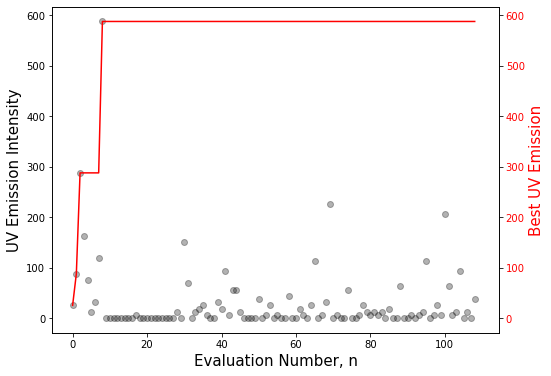

iterations to the max UV: 109.0+/-0.0


In [29]:
import matplotlib.pyplot as plt
from botorch.acquisition import UpperConfidenceBound
    
plt.figure(0)
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

max_x = 0
max_y = 0
steps = []
UVs=[]
#for i in [9]:
for i in range(len(log_seed)):
    max_xi, max_yi = add_one_ensemble(log_seed,i)
    steps.append(max_xi)
    UVs.append(max_yi)
    max_x = max(max_xi,max_x)
    max_y = max(max_yi,max_y)

FontSize = 15
ax1.set_ylim(-max_y*0.05,max_y*1.05)
ax2.set_ylim(-max_y*0.05,max_y*1.05)
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission', color='r', fontsize = FontSize)
plt.setp(ax2.get_yticklabels(), color="red")
# plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
# plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([-max_x*0.05,max_x*1.05])
    
plt.show()
print(f'iterations to the max UV: {np.mean(steps)}+/-{np.std(steps)}')

In [30]:
# save log_seed
import pickle
# write to Pickle
pickle.dump(log_seed, open( "pool_based_tuning/100iters_10inits_100trials_linEmission_PI_init_included.pkl", "wb" ) )
